In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import importlib

from tqdm import tqdm_notebook

In [32]:
try: importlib.reload(msp)
except: import ModSimPy as msp

# Модель 1

Просто работает с 07:00 до 19:00

In [152]:
def step(system, state):
    if msp.flip(1/60/60):
        state.n_busy_lines += 1

In [153]:
def run_simulation(system):
    state = msp.State(time_cur=system.time_start,
                      n_busy_lines=0)
    results_busy_lines = msp.TimeSeries()
    
    tqdm = tqdm_notebook(total=(system.time_end-system.time_start).seconds//system.timedelta.seconds)
    while state.time_cur<system.time_end:
        step(system, state)
        
        results_busy_lines[state.time_cur] = state.n_busy_lines
        
        state.time_cur += system.timedelta
        tqdm.update(system.timedelta.seconds)
    tqdm.close()
    results_frame = msp.TimeFrame()
    results_frame['busy_lines'] = results_busy_lines
    return results_frame

In [157]:
system = msp.System(time_start=datetime.datetime(2018,1,1,7,0),
                time_end=datetime.datetime(2018,1,1,19,0),
                #time_end=datetime.datetime(2018,1,1,8,0),
                timedelta = datetime.timedelta(seconds=1),
                n_lines = 50)

In [158]:
results = run_simulation(system)

A Jupyter Widget

In [160]:
results.head()

,busy_lines
2018-01-01 07:00:00,0
2018-01-01 07:00:01,0
2018-01-01 07:00:02,0
2018-01-01 07:00:03,0
2018-01-01 07:00:04,0


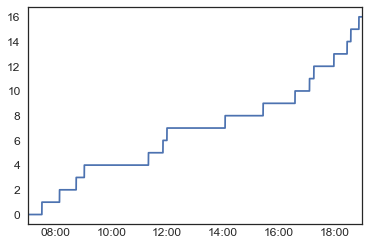

In [161]:
results['busy_lines'].plot()
plt.show()